In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, silhouette_score, mean_squared_error, mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# create dataframes of csv
player_stats_salaries_df = pd.read_csv('./data/player_stats_salaries.csv')


In [3]:
#New index was created
player_stats_salaries_df.head()

,Unnamed: 0,Player,Club,POS,GP,GS,MINS,G,A,SHTS,...,FC,FS,OFF,YC,RC,SOG%,Year,Season,Base Salary,Base Guaranteed Comp.
0,0,luciano emilio,DC,F,29,28,2410,20,1,79,...,35,39,21,2,0,59.49,2007,reg,265000.0,293125.0
1,1,juan pablo angel,NY,F,24,24,2125,19,5,97,...,31,20,42,2,1,54.64,2007,reg,1500000.0,1593750.0
2,2,taylor twellman,NE,F,26,25,2283,16,3,90,...,13,41,21,2,0,61.11,2007,reg,325008.0,350008.0
3,4,maykel galindo,CHV,F,28,24,2021,12,5,55,...,44,53,30,6,0,50.91,2007,reg,72500.0,72500.0
4,5,ante razov,CHV,F,26,24,2041,11,8,85,...,37,33,30,2,0,49.41,2007,reg,245000.0,248750.0


In [4]:
# remove Unnamed column
player_stats_salaries_df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
player_stats_salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6161 entries, 0 to 6160
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player                 6161 non-null   object 
 1   Club                   6161 non-null   object 
 2   POS                    6161 non-null   object 
 3   GP                     6161 non-null   int64  
 4   GS                     6161 non-null   int64  
 5   MINS                   6161 non-null   int64  
 6   G                      6161 non-null   int64  
 7   A                      6161 non-null   int64  
 8   SHTS                   6161 non-null   int64  
 9   SOG                    6161 non-null   int64  
 10  GWG                    6161 non-null   int64  
 11  PKG/A                  6161 non-null   object 
 12  HmG                    6161 non-null   int64  
 13  RdG                    6161 non-null   int64  
 14  G/90min                6161 non-null   float64
 15  SC% 

In [6]:
for i in range(len(player_stats_salaries_df)):
    pos = player_stats_salaries_df.at[i, 'POS']
    if pos == 'M-F':
        player_stats_salaries_df.at[i, 'POS'] = 'M'
    elif pos == 'D-M':
        player_stats_salaries_df.at[i, 'POS'] = 'D'
    elif pos == 'F-M':
        player_stats_salaries_df.at[i, 'POS'] = 'F'
    elif pos == 'M-D':
        player_stats_salaries_df.at[i, 'POS'] = 'M'

In [7]:
one_hot = pd.get_dummies(player_stats_salaries_df['POS'])
one_hot

,D,F,M
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False
...,...,...,...
6156,True,False,False
6157,False,False,True
6158,False,False,True
6159,False,False,True


In [8]:
one_hot['D'] = one_hot['D'].astype(int)
one_hot['F'] = one_hot['F'].astype(int)
one_hot['M'] = one_hot['M'].astype(int)
one_hot

,D,F,M
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
6156,1,0,0
6157,0,0,1
6158,0,0,1
6159,0,0,1


In [9]:
player_stats_salaries_df['Defender'] = one_hot['D']
player_stats_salaries_df['Forward'] = one_hot['F']
player_stats_salaries_df['Midfielder'] = one_hot['M']
player_stats_salaries_df.drop(columns='POS', inplace=True)

In [10]:
player_stats_salaries_df

,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,YC,RC,SOG%,Year,Season,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder
0,luciano emilio,DC,29,28,2410,20,1,79,47,4,...,2,0,59.49,2007,reg,265000.0,293125.0,0,1,0
1,juan pablo angel,NY,24,24,2125,19,5,97,53,5,...,2,1,54.64,2007,reg,1500000.0,1593750.0,0,1,0
2,taylor twellman,NE,26,25,2283,16,3,90,55,5,...,2,0,61.11,2007,reg,325008.0,350008.0,0,1,0
3,maykel galindo,CHV,28,24,2021,12,5,55,28,5,...,6,0,50.91,2007,reg,72500.0,72500.0,0,1,0
4,ante razov,CHV,26,24,2041,11,8,85,42,4,...,2,0,49.41,2007,reg,245000.0,248750.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,nedum onuoha,RSL,15,15,1318,0,0,12,2,0,...,0,0,16.67,2020,reg,549996.0,603996.0,1,0,0
6157,sacha kljestan,LA,15,8,769,0,0,13,4,0,...,2,0,30.77,2020,reg,307000.0,307000.0,0,0,1
6158,judson,SJ,21,20,1701,0,0,14,1,0,...,4,0,7.14,2020,reg,320000.0,325000.0,0,0,1
6159,kelyn rowe,NE,16,10,896,0,0,17,4,0,...,3,0,23.53,2020,reg,310610.0,310610.0,0,0,1


In [11]:
minimum_salary = {2007: 30000, 2008: 33000, 2009: 34000, 2010: 40000, 2011: 42000, 2012: 45000, 2013: 46500,
                  2014: 48500, 2015: 60000, 2016: 62500, 2017: 65000, 2018: 67500, 2019: 70250, 2020: 81375}

player_stats_salaries_df['Minimum_Salary'] = player_stats_salaries_df['Year'].apply(lambda year: minimum_salary.get(year, 0))



In [12]:
player_stats_salaries_df[player_stats_salaries_df['Base Salary'] < player_stats_salaries_df['Minimum_Salary']]

,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,RC,SOG%,Year,Season,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder,Minimum_Salary
33,adam cristman,NE,28,14,1421,4,4,40,16,0,...,0,40.00,2007,reg,17700.0,17700.0,0,1,0,30000
71,colin clark,COL,16,16,1321,2,2,26,5,0,...,0,19.23,2007,reg,17700.0,17700.0,0,0,1,30000
76,kyle brown,RSL,8,3,286,2,0,7,4,1,...,0,57.14,2007,reg,17700.0,17700.0,0,1,0,30000
106,jeff curtin,CHI,3,3,248,1,0,2,1,0,...,1,50.00,2007,reg,12900.0,12900.0,1,0,0,30000
109,floyd franks,CHI,7,2,223,1,0,3,1,0,...,0,33.33,2007,reg,17700.0,17700.0,0,0,1,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6106,tah brian anunga,NSH,14,8,779,0,0,3,0,0,...,0,0.00,2020,reg,63547.0,63547.0,0,0,1,81375
6108,kamal miller,ORL,12,9,805,0,0,3,0,0,...,0,0.00,2020,reg,63547.0,63547.0,1,0,0,81375
6118,alan winn,NSH,7,1,239,0,0,4,1,0,...,0,25.00,2020,reg,63547.0,63547.0,0,1,0,81375
6119,laurence wyke,ATL,7,2,226,0,0,4,1,0,...,0,25.00,2020,reg,63547.0,63547.0,1,0,0,81375


In [13]:
for i, salary in player_stats_salaries_df.iterrows():
    if player_stats_salaries_df.at[i, 'Base Salary'] < player_stats_salaries_df.at[i, 'Minimum_Salary']:
        player_stats_salaries_df.drop(i, inplace=True)

In [14]:
player_stats_salaries_df

,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,RC,SOG%,Year,Season,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder,Minimum_Salary
0,luciano emilio,DC,29,28,2410,20,1,79,47,4,...,0,59.49,2007,reg,265000.0,293125.0,0,1,0,30000
1,juan pablo angel,NY,24,24,2125,19,5,97,53,5,...,1,54.64,2007,reg,1500000.0,1593750.0,0,1,0,30000
2,taylor twellman,NE,26,25,2283,16,3,90,55,5,...,0,61.11,2007,reg,325008.0,350008.0,0,1,0,30000
3,maykel galindo,CHV,28,24,2021,12,5,55,28,5,...,0,50.91,2007,reg,72500.0,72500.0,0,1,0,30000
4,ante razov,CHV,26,24,2041,11,8,85,42,4,...,0,49.41,2007,reg,245000.0,248750.0,0,1,0,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,nedum onuoha,RSL,15,15,1318,0,0,12,2,0,...,0,16.67,2020,reg,549996.0,603996.0,1,0,0,81375
6157,sacha kljestan,LA,15,8,769,0,0,13,4,0,...,0,30.77,2020,reg,307000.0,307000.0,0,0,1,81375
6158,judson,SJ,21,20,1701,0,0,14,1,0,...,0,7.14,2020,reg,320000.0,325000.0,0,0,1,81375
6159,kelyn rowe,NE,16,10,896,0,0,17,4,0,...,0,23.53,2020,reg,310610.0,310610.0,0,0,1,81375


In [15]:
player_stats_salaries_df.rename(columns={'PKG/A': 'Penalty_Kick_Conversion_Rate', 'G/90min': 'Goals_per_90_Minutes', 
                                          'A/90min': 'Assists_per_90_Minutes', 'GP': 'Games_Played',
                                         'GS': 'Games_Started', 'MINS': 'Total_Minutes_Played', 'G': 'Goals',
                                         'A': 'Assists', 'SHTS': 'Shots', 'SOG': 'Shots_On_Goal', 
                                        'GWG': 'Game_Winning_Goals', 'HmG': 'Home_Goals', 'RdG': 'Road_Goals',
                                        'SC%': 'Shots_Conversion', 'GWA': 'Game_Winning_Assists',
                                        'HmA': 'Home_Assists', 'RdA': 'Road_Assists', 'FC': 'Fouls_Committed',
                                        'FS': 'Fouls_Suffered', 'OFF': 'Offsides', 'YC': 'Yellow_Cards',
                                        'RC': 'Red_Cards', 'SOG%': 'Shots_On_Goal_Rate'}, inplace=True)

In [16]:
player_stats_salaries_df['Penalty_Kick_Conversion_Rate']

0       0/0
1       5/5
2       0/0
3       0/0
4       1/1
       ... 
6156    0/0
6157    0/0
6158    0/0
6159    0/0
6160    0/0
Name: Penalty_Kick_Conversion_Rate, Length: 5367, dtype: object

In [17]:
player_stats_salaries_df = player_stats_salaries_df[player_stats_salaries_df['Total_Minutes_Played'] != 0]

In [18]:
player_stats_salaries_df[["Penalty_Kicks_Scored", "Penalty_Kicks_Taken"]] = player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].str.split("/", expand=True)
player_stats_salaries_df['Penalty_Kick_Conversion_Rate'] = player_stats_salaries_df["Penalty_Kicks_Scored"].astype(float) / player_stats_salaries_df["Penalty_Kicks_Taken"].astype(float)
player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].fillna(value=0, inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_50658/132888053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df[["Penalty_Kicks_Scored", "Penalty_Kicks_Taken"]] = player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].str.split("/", expand=True)
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_50658/132888053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df[["Penalty_Kicks_Scored", "Penalty_Kicks_Taken"]] = player_stats_salaries

In [19]:
player_stats_salaries_df['Shots_On_Goal_Rate'].fillna(value=0, inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_50658/825700931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df['Shots_On_Goal_Rate'].fillna(value=0, inplace=True)


In [20]:
salary_cap = {2007: 2100000, 2008: 2300000, 2009: 2300000, 2010: 2550000, 2011: 2670000, 2012: 2810000, 2013: 2950000, 2014: 3100000, 2015: 3490000, 2016: 3660000, 2017: 3845000,
              2018: 4035000, 2019: 4240000, 2020: 4900000}
player_stats_salaries_df['Salary Cap'] = player_stats_salaries_df['Year'].apply(lambda year: salary_cap.get(year, 0))

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_50658/1585667694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df['Salary Cap'] = player_stats_salaries_df['Year'].apply(lambda year: salary_cap.get(year, 0))


In [21]:
player_stats_salaries_df['Bonus Pay'] = player_stats_salaries_df['Base Guaranteed Comp.'] - player_stats_salaries_df['Base Salary']

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_50658/1575893766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df['Bonus Pay'] = player_stats_salaries_df['Base Guaranteed Comp.'] - player_stats_salaries_df['Base Salary']


In [22]:
stats_salaries_df = player_stats_salaries_df.drop(columns=['Player', 'Club', 'Season', 'Base Guaranteed Comp.'
                                                           ])

In [23]:
stats_salaries_df

,Games_Played,Games_Started,Total_Minutes_Played,Goals,Assists,Shots,Shots_On_Goal,Game_Winning_Goals,Penalty_Kick_Conversion_Rate,Home_Goals,...,Year,Base Salary,Defender,Forward,Midfielder,Minimum_Salary,Penalty_Kicks_Scored,Penalty_Kicks_Taken,Salary Cap,Bonus Pay
0,29,28,2410,20,1,79,47,4,0.0,12,...,2007,265000.0,0,1,0,30000,0,0,2100000,28125.0
1,24,24,2125,19,5,97,53,5,1.0,13,...,2007,1500000.0,0,1,0,30000,5,5,2100000,93750.0
2,26,25,2283,16,3,90,55,5,0.0,7,...,2007,325008.0,0,1,0,30000,0,0,2100000,25000.0
3,28,24,2021,12,5,55,28,5,0.0,8,...,2007,72500.0,0,1,0,30000,0,0,2100000,0.0
4,26,24,2041,11,8,85,42,4,1.0,9,...,2007,245000.0,0,1,0,30000,1,1,2100000,3750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,15,15,1318,0,0,12,2,0,0.0,0,...,2020,549996.0,1,0,0,81375,0,0,4900000,54000.0
6157,15,8,769,0,0,13,4,0,0.0,0,...,2020,307000.0,0,0,1,81375,0,0,4900000,0.0
6158,21,20,1701,0,0,14,1,0,0.0,0,...,2020,320000.0,0,0,1,81375,0,0,4900000,5000.0
6159,16,10,896,0,0,17,4,0,0.0,0,...,2020,310610.0,0,0,1,81375,0,0,4900000,0.0


In [24]:
stats_salaries_df['Penalty_Kicks_Scored'] = stats_salaries_df['Penalty_Kicks_Scored'].astype(int)
stats_salaries_df["Penalty_Kicks_Taken"]= stats_salaries_df['Penalty_Kicks_Taken'].astype(int)

In [25]:
X = stats_salaries_df.drop(columns='Base Salary')
y = stats_salaries_df['Base Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

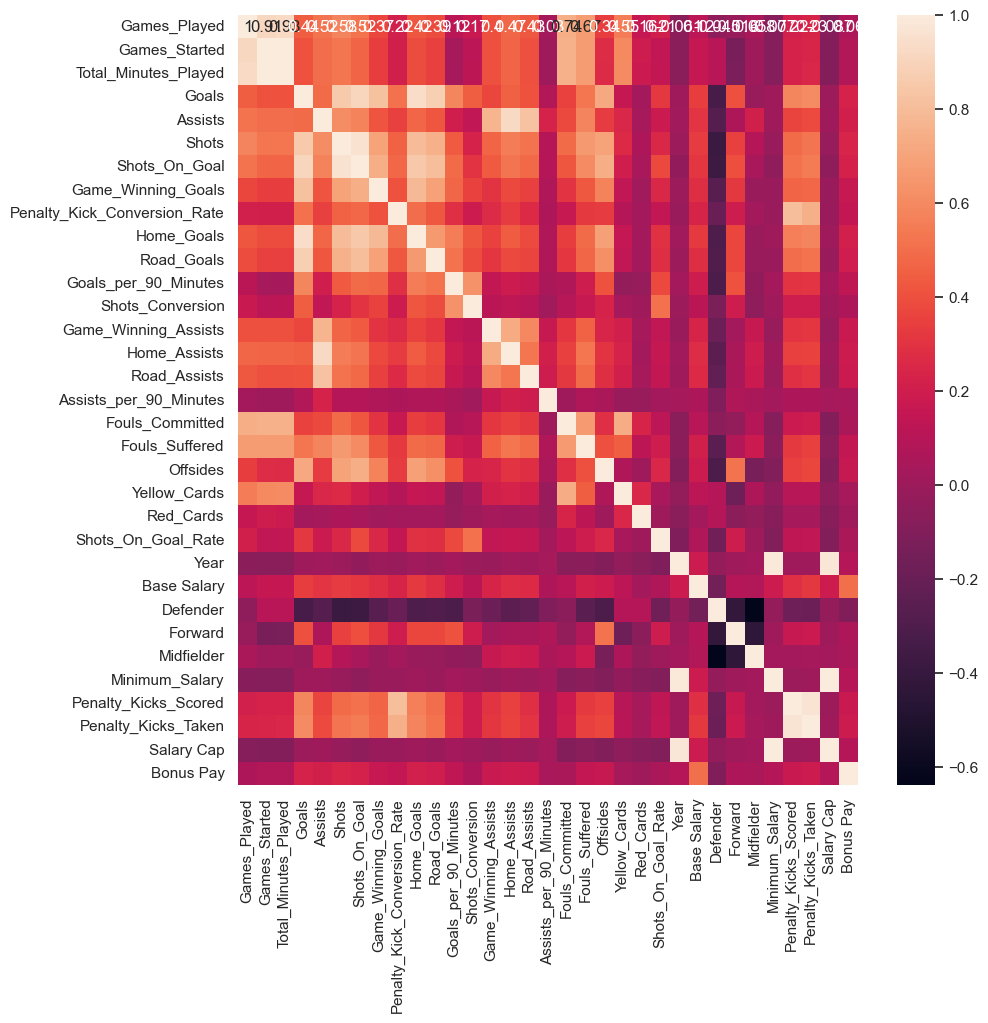

In [26]:
sns.set(rc={'figure.figsize': (10, 10)})

sns.heatmap(stats_salaries_df.corr(), annot=True);

In [27]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)

DummyRegressor()

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

dummy_mse = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
dummy_mse

-402280238977.02185

In [ ]:
dummy_rmse = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error'))
dummy_rmse

[CV] END pca__n_components=50, rf__criterion=poisson, rf__min_samples_split=3, rf__n_estimators=75; total time=   0.0s
[CV] END pca__n_components=50, rf__criterion=poisson, rf__min_samples_split=3, rf__n_estimators=75; total time=   0.0s
[CV] END pca__n_components=50, rf__criterion=poisson, rf__min_samples_split=3, rf__n_estimators=75; total time=   0.0s
[CV] END pca__n_components=50, rf__criterion=poisson, rf__min_samples_split=3, rf__n_estimators=75; total time=   0.0s
[CV] END pca__n_components=50, rf__criterion=poisson, rf__min_samples_split=3, rf__n_estimators=75; total time=   0.0s
[CV] END pca__n_components=50, rf__criterion=poisson, rf__min_samples_split=3, rf__n_estimators=125; total time=   0.0s
[CV] END pca__n_components=50, rf__criterion=poisson, rf__min_samples_split=3, rf__n_estimators=125; total time=   0.0s
[CV] END pca__n_components=50, rf__criterion=poisson, rf__min_samples_split=3, rf__n_estimators=125; total time=   0.0s
[CV] END pca__n_components=50, rf__criterion=

In [30]:
y_pred = dummy.predict(X_train)

dummy_score = r2_score(y_train, y_pred)
dummy_score

0.0

In [31]:
dummy_mae = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error'))
dummy_mae

-286589.1683311273

In [32]:
lr = LinearRegression()
scaler = StandardScaler()
X_train_sc= scaler.fit_transform(X_train)
X_test_sc= scaler.transform(X_test)

lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_train_sc)

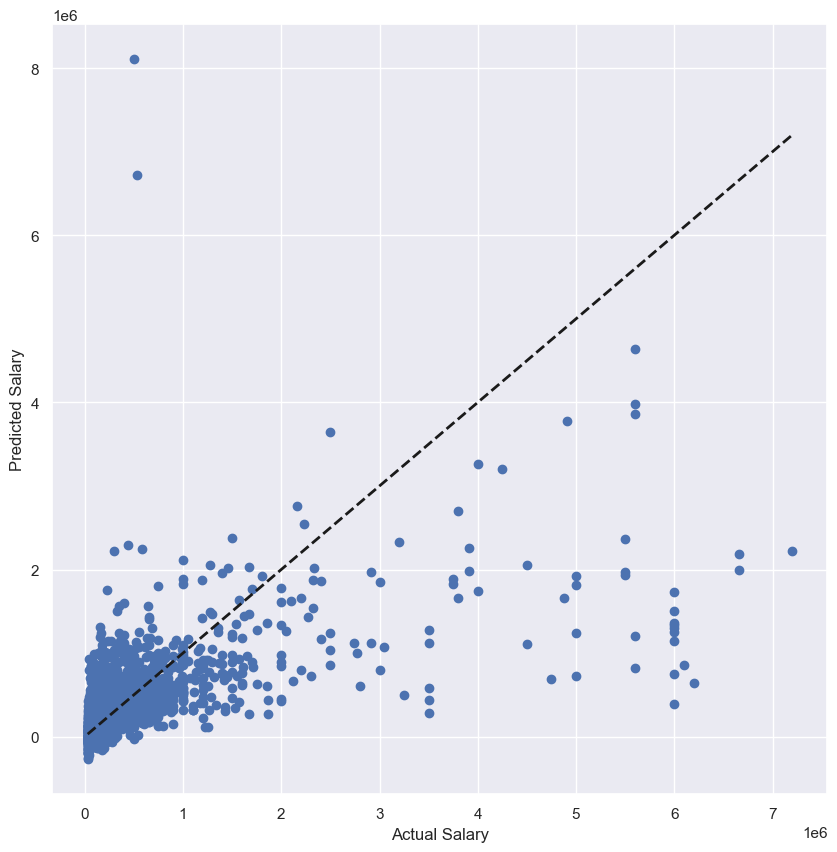

In [33]:
plt.scatter(y_train, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.show()

In [34]:
lr_mse = np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_squared_error'))
lr_mse

-307701612297.32306

554708.5832194443

In [36]:
rmse = np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_root_mean_squared_error'))
rmse

-538881.085320706

In [37]:
lr_mae =  np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
lr_mae

-218685.19537609155

In [38]:
y_pred_lr = lr.predict(X_train_sc)

lr_score =  np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'r2'))
lr_score

0.25563544084429435

In [39]:
pipe = Pipeline([
    ('pca', PCA(random_state=42)),
    ('lr', LinearRegression())
])
    

In [40]:
param_grid = {
    'pca__n_components': [23, 24, 25],
    'pca__copy': [False, True],
    'pca__whiten': [False, True]
}   

In [41]:
grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=kf, verbose=2, return_train_score=True)
grid.fit(X_train_sc, y_train)
print(grid.best_score_)
print(grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.25297742860066
{'pca__copy': False, 'pca__n_components': 25, 'pca__whiten': True}


In [42]:
#stats_salaries_df[['Goals_per_90', 'Assists_per_90', 'Shots_per_90', 'Shots_on_Goal_per_90', 'Game_Winning_Goals_per_90',
#                   'Game_Winning_Assists_per_90', 'Fouls_Committed_per_90', 'Fouls_Suffered_per_90', 'Offsides_per_90',
#                   'Yellow_Cards_per_90', 'Red_Cards_per_90', 'Base_Salary_per_90']] = stats_salaries_df[['Goals', 'Assists', 'Shots',
#                        'Shots_On_Goal', 'Game_Winning_Goals', 'Game_Winning_Assists', 'Fouls_Committed', 'Fouls_Suffered', 
#                        'Offsides','Yellow_Cards', 'Red_Cards', 'Base Salary']].div((stats_salaries_df['Total_Minutes_Played'] / 90), axis=0)

In [43]:
#stats_salaries_df.fillna(value=0, inplace=True)

In [44]:
#stats_salaries_df['Games_Played'] = stats_salaries_df['Total_Minutes_Played'] / 90

In [45]:
#sns.set(rc={'figure.figsize': (10, 10)})

#sns.heatmap(stats_salaries_df.corr(), annot=True);

In [46]:
#salary90_corrs = stats_salaries_df.corr()['Base_Salary_per_90'].map(abs).sort_values(ascending=False)
#salary90_corrs

In [47]:
#stats_salaries_df.drop(columns=['Fouls_Committed', 'Yellow_Cards', 'Red_Cards', 'Goals_per_90_Minutes', 'Assists_per_90_Minutes',
                        #'Penalty_Kick_Conversion_Rate', 'Shots_Conversion', 'Shots_On_Goal_Rate'], inplace=True)

In [48]:
rf = RandomForestRegressor(random_state=42)

In [49]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [50]:
rf_score = np.mean(cross_val_score(rf, X_train, y_train, cv=5))
rf_score

0.5031766165522074

In [51]:
rf_mse = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring = 'neg_mean_squared_error'))
rf_mse

-190464896897.59424

In [52]:
rf_rmse = np.sqrt(-rf_mse)
rf_rmse

436422.8418604991

In [53]:
rf_mae = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
rf_mae

-172617.91072398497

In [54]:
rfpipe = Pipeline([('pca', PCA(random_state=42)),
                    ('rf', RandomForestRegressor(random_state=42))])

In [55]:
rf_param_grid = {
    'pca__n_components': [10, 20, 30],
    'rf__n_estimators': [10, 50, 100],
    'rf__min_samples_split': [2, 5, 10],
    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
}
    

In [56]:
rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, verbose=2, n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0.5356731286834426
{'pca__n_components': 30, 'rf__criterion': 'poisson', 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


In [57]:
rf_param_grid = {
    'pca__n_components': [30, 50, 70],
    'rf__n_estimators': [75, 125, 175],
    'rf__min_samples_split': [3, 5, 7],
    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
}
    

In [58]:
rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, verbose=2, n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END pca__copy=False, pca__n_components=24, pca__whiten=False; total time=   0.1s
[CV] END pca__n_components=10, rf__criterion=squared_error, rf__min_samples_split=2, rf__n_estimators=10; total time=   0.4s
[CV] END pca__n_components=10, rf__criterion=squared_error, rf__min_samples_split=5, rf__n_estimators=10; total time=   0.4s
[CV] END pca__n_components=10, rf__criterion=squared_error, rf__min_samples_split=5, rf__n_estimators=50; total time=   2.5s
[CV] END pca__n_components=10, rf__criterion=squared_error, rf__min_samples_split=10, rf__n_estimators=50; total time=   2.2s
[CV] END pca__n_components=10, rf__criterion=friedman_mse, rf__min_samples_split=2, rf__n_estimators=10; total time=   0.5s
[CV] END pca__n_components=10, rf__criterion=friedman_mse, rf__min_samples_split=2, rf__n_estimators=50; total time=   3.0s
[CV] END pca__n_components=10, rf__criterion=friedman_mse, rf__min_samples_split=5, rf__n_estimators=50

/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
270 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users

0.5367797276507584
{'pca__n_components': 30, 'rf__criterion': 'poisson', 'rf__min_samples_split': 7, 'rf__n_estimators': 175}


In [59]:
rf_param_grid = {
    'pca__n_components': [25, 30, 32],
    'rf__n_estimators': [145, 160, 175],
    'rf__min_samples_split': [4, 5, 6],
    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
}
    

In [60]:
rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, verbose=2, n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0.53802096934218
{'pca__n_components': 32, 'rf__criterion': 'poisson', 'rf__min_samples_split': 5, 'rf__n_estimators': 175}


In [61]:
pca = PCA()
pca.fit(X_train_sc, y_train)


PCA()

In [62]:
knn = KNeighborsRegressor()

In [63]:
knn.fit(X_train_sc, y_train)

KNeighborsRegressor()

In [64]:
y_pred_k = knn.predict(X_train_sc)
y_pred_k

array([610051.624, 182148.408, 318800.808, ..., 130000.   , 182790.   ,
        95519.392])

In [65]:
knn_train = knn.score(X_train_sc, y_train)
knn_val = knn.score(X_test_sc, y_test)
print(knn_train)
print(knn_val)

0.5934023630915399
0.22314731880522687


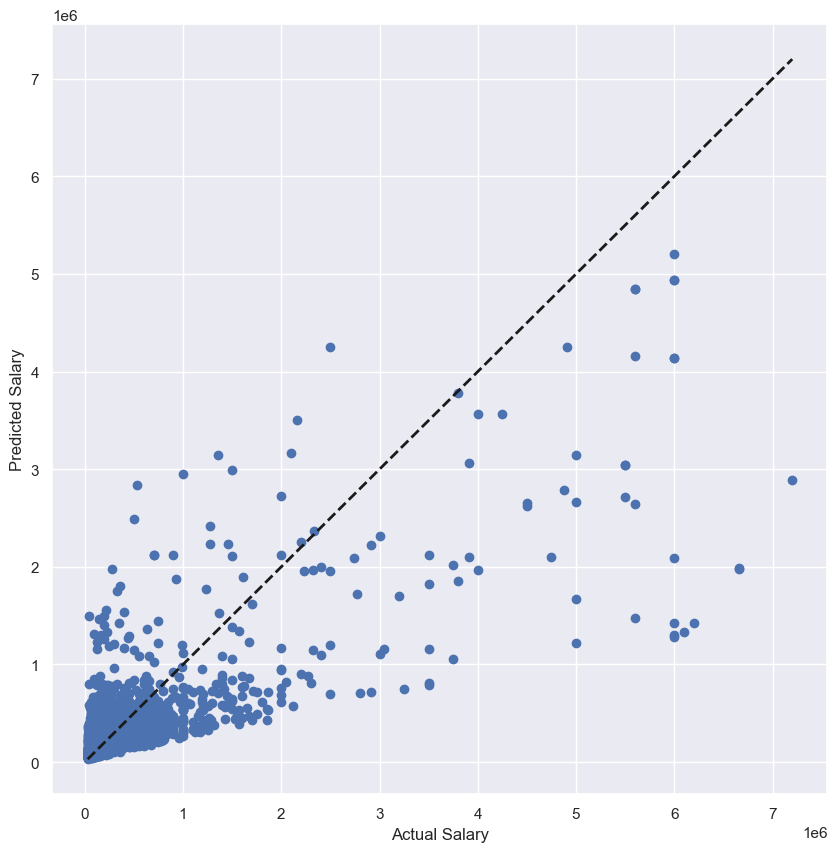

In [66]:
plt.scatter(y_train, y_pred_k)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.show()

In [67]:
X_test= np.linspace(X_train_sc.min(), X_train_sc.max(), 500)[:, np.newaxis]

ValueError: x and y must be the same size

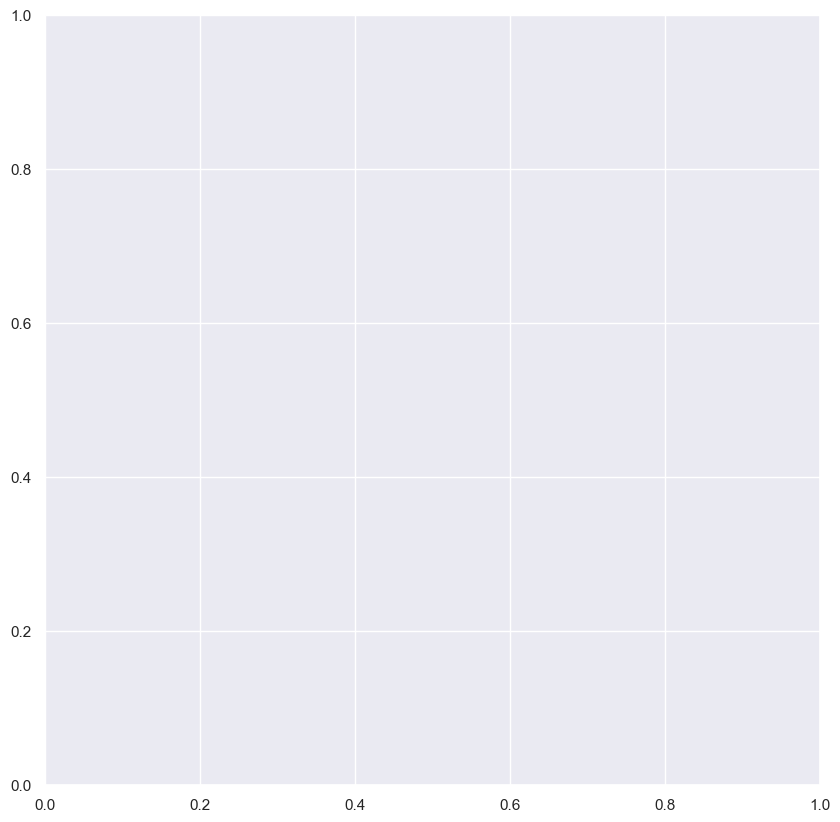

In [68]:
plt.scatter(X_train_sc, y_train, color='red', label='Training Data')
plt.plot(X_train_sc, X_test, color='blue', label='True Values')
plt.plot(X_train_sc, y_pred_k, color='green', label='Predicted Values')
plt.xlabel('X')
plt.ylabel('y')
plt.title('KNeighborsRegressor')
plt.legend()
plt.show()

In [ ]:
knn_mse = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=5, scoring = 'neg_mean_squared_error'))
knn_mse

In [ ]:
knn_rmse = np.sqrt(-knn_mse)
knn_rmse

In [ ]:
knn_mae = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
knn_mae

In [ ]:
knn_r2 = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring = 'r2'))
knn_r2

In [ ]:
kpipe = Pipeline([('pca', PCA(random_state=42)),
                  ('knn', KNeighborsRegressor())
                 ])
                   

In [ ]:
k_param_grid = {
    'pca__n_components': [5, 10, 15],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [ ]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=kf, verbose=2, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

In [ ]:
k_param_grid = {
    'pca__n_components': [7, 10, 13],
    'knn__n_neighbors': [7, 15, 23],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [ ]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=kf, verbose=2, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

In [ ]:
k_param_grid = {
    'pca__n_components': [3, 5, 7],
    'knn__n_neighbors': [17, 20, 23],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [ ]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=5, verbose=2, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

In [ ]:
k_rmse_values = []
k_values = range(1, 10)
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred_k = knn.fit(X_train_sc, y_train).predict(X_train_sc)
    k_mse = mean_squared_error(y_train, y_pred_k)
    k_rmse = np.sqrt(k_mse)
    k_rmse_values.append(k_rmse)



In [ ]:
k_rmse_v_values = []
k_values = range(1, 10)
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred_vk = knn.fit(X_test_sc, y_test).predict(X_test_sc)
    k_vmse = mean_squared_error(y_test, y_pred_vk)
    k_vrmse = np.sqrt(k_vse)
    k_rmse_v_values.append(k_vrmse)


In [ ]:
sns.lineplot(x = k_values, y = k_rmse_values, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("RMSE")
plt.show()

In [ ]:
sns.lineplot(x = k_values, y = k_rmse_v_values, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("RMSE")
plt.show()

In [ ]:
knn_score= np.mean(cross_val_score(knn, X_train_sc, y_train, cv=5))
knn_score

In [ ]:
knn_score = knn.score(X_train_sc, y_train)
knn_score

In [ ]:
knn_score_values = []
k_values = range(1, 10)
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred_k = knn.fit(X_train_sc, y_train).predict(X_train_sc)
    knn_score = knn.score(X_train_sc, y_train)
    knn_score_values.append(knn_score)



In [ ]:
sns.lineplot(x = k_values, y = knn_score_values, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy")